# Russian vs English

In [1]:
%env THEANO_FLAGS="device=gpu6"
import theano
import theano.tensor as T
import lasagne

env: THEANO_FLAGS="device=gpu6"


Using gpu device 6: GeForce GTX 1080 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)


In [2]:
!env | grep -i theano

THEANO_FLAGS="device=gpu6"


In [3]:
import numpy as np
import os

In [4]:
from voice2vec.data.spectograms import get_spectrogram
# from voice2vec.neural.model import Speech2VecLayer

In [93]:
wav_files = "music_mp3/"
russian_p = wav_files + "russian_dataset/data/"
english_p = wav_files + "english_dataset/new/data/"

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

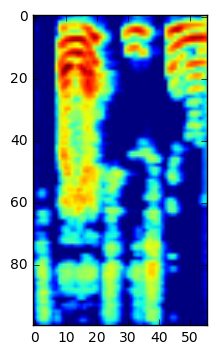

In [7]:
plt.imshow(get_spectrogram(russian_p + "10.wav"))

In [ ]:
engrus = theano.function([input_v], predict, allow_input_downcast=True)

In [89]:
def load_song_base(file):
    try:
        spect = get_spectrogram(file)
    except IndexError:
        return []
    answ = []
    for i in range(0, 10, 5):
        if i+mus_len >= spect.shape[-1]:
            break
        answ.append(spect[:, i:i+mus_len])
    return answ

def load_song_rus(file):
    return load_song_base(russian_p + file)

def load_song_eng(file):
    return load_song_base(english_p + file)

In [ ]:
np.array(load_song_rus("1.wav")).shape

In [24]:
from multiprocessing import Pool
mpool = Pool(2)

In [90]:
def load_sequence(data, lang):
    pool = Pool(2)
    if lang == "rus":
        load_song = load_song_rus
    else:
        load_song = load_song_eng
    
#     ret = list(pool.map(load_song, data))
#     ret_song = []
#     for s in ret:
#         ret_song.extend(ret_song)
#      = list(pool.map(load_song, data))
    ret_song = []
    for s in data:
        ret_song.extend(load_song(s))
    return np.array(ret_song)

In [97]:
russian_song = list(filter(lambda x: x.endswith(".wav"), os.listdir(russian_p)))
english_song = list(filter(lambda x: x.endswith(".wav"), os.listdir(english_p)))[:4000]

In [18]:
def load_ru(data):
    return load_sequence(data, "rus")
def load_eng(data):
    return load_sequence(data, "eng")

# Считается долго, загрузите из готового

In [98]:
russian_song_m = load_sequence(russian_song, "rus")
print(russian_song_m.shape)
english_song_m = load_sequence(english_song, "eng")
print(english_song_m.shape)

(7996, 100, 50)


# Сохраняем

In [99]:
np.save("Russian_50.npy", russian_song_m)
np.save("English_50.npy", english_song_m)

In [ ]:
np.array(russian_song_m).shape, english_song_m

In [ ]:
len(russian_song), len(english_song)

## Deep learning

In [68]:
mus_len = 50

In [69]:
shape = (None, 100, mus_len)
input_v = T.tensor3(name="input_sound")
true_val = T.vector(name="Russian or English", dtype="int32")

In [319]:
input_ = lasagne.layers.InputLayer(shape, input_var=input_v)
# Tvorog = Speech2VecLayer(input_, (100, 25), 100, name="Tvorog")
conv1 = lasagne.layers.Conv1DLayer(input_, 100, 5, nonlinearity=lasagne.nonlinearities.very_leaky_rectify, name="conv song 0")
conv2 = lasagne.layers.Conv1DLayer(conv1, 150, 6, nonlinearity=lasagne.nonlinearities.very_leaky_rectify, name="conv song 1")
conv3 = lasagne.layers.Conv1DLayer(conv2, 200, 6, nonlinearity=lasagne.nonlinearities.very_leaky_rectify, name="conv song 2")
pool = lasagne.layers.GlobalPoolLayer(conv3, pool_function=T.max, name="pool song")
dense = lasagne.layers.DenseLayer(pool, 200, name="Dense")
vec_out = lasagne.layers.DenseLayer(dense, 100, nonlinearity=lasagne.nonlinearities.tanh)

nn = vec_out#lasagne.layers.DenseLayer(vec_out, 75)
#nn = lasagne.layers.DenseLayer(nn, 50)
#nn = lasagne.layers.DenseLayer(nn, 25)
#nn = lasagne.layers.DenseLayer(nn, 10)
output_ = lasagne.layers.DenseLayer(nn, 1, nonlinearity=lasagne.nonlinearities.sigmoid)

In [320]:
predict = lasagne.layers.get_output(output_)
params = lasagne.layers.get_all_params(output_,trainable=True)

In [321]:
loss = lasagne.objectives.binary_crossentropy(predict, true_val).mean()

accuracy = lasagne.objectives.binary_accuracy(predict, true_val).mean()

update = lasagne.updates.adam(loss, params,learning_rate=0.001)

In [322]:
train = theano.function([input_.input_var, true_val], [loss, accuracy,predict], updates=update, allow_input_downcast=True)
accur = theano.function([input_.input_var, true_val], accuracy, allow_input_downcast=True)

In [323]:
def sequence(ind, size):
    res = []
    for i in range(0, len(ind)-size, size):
        res.append(ind[i:i+size])
    return res
    

def iterate_minibatches(russian, english, batchsize):
    rus_i = np.arange(len(russian))
    eng_i = np.arange(len(english))
    lang_size = batchsize//2
    
#     print(len(russian), len(english))
    
    np.random.shuffle(rus_i)
    np.random.shuffle(eng_i)
    
    rus_seq = sequence(rus_i, lang_size)
    eng_seq = sequence(eng_i, lang_size)
    
    len_min = min(len(rus_seq), len(eng_seq))
    
    rus_seq = rus_seq[:len_min]
    eng_seq = eng_seq[:len_min]
    
    russian = np.array(russian)
    english = np.array(english)
    
#     print(len_min)
#     print(rus_seq, eng_seq)
    
    for rus, eng in zip(rus_seq, eng_seq):
#         print("hey")
        russ = russian[rus]
        y = [0 for _ in range(len(russ))]
        engs = english[eng]
        y.extend([1 for _ in range(len(engs))])

        ret_song = np.vstack((russ, engs))
#         print(russ.shape, engs.shape)
        
        ind = np.arange(len(ret_song))
        np.random.shuffle(ind)
        
        ret_song = np.array(ret_song)
        y = np.array(y)
        yield ret_song[ind], y[ind]

In [41]:
sequence([i for i in range(100)], 10)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
 [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
 [80, 81, 82, 83, 84, 85, 86, 87, 88, 89]]

In [324]:
russ_test, russ_val, russ_tr = russian_song_m[:100]/80., russian_song_m[100:200]/80., russian_song_m[200:]/80.
engs_test, engs_val, engs_tr = english_song_m[:100]/80., english_song_m[100:200]/80., english_song_m[200:]/80.

(4724, 100, 25)

In [54]:
for X, y in iterate_minibatches(russ_tr, engs_tr, 100):
    print(X.shape, y.shape)
    break

(50, 100, 25) (50, 100, 25)
(100, 100, 25) (100,)


## Учимся

In [325]:
from time import time

In [327]:
NUM_EPOCH = 100
BATCH_SIZE = 100
BATCH_PER_EPOCH = 100

ac = []
for epoch in range(NUM_EPOCH):
    st = time()
    train_loss = 0
    train_acc = 0
    batch_count = 0
    for X, y in iterate_minibatches(russ_tr, engs_tr, BATCH_SIZE):
        batch_loss, batch_acc,_ = train(X, y)
        train_loss += batch_loss
        train_acc += batch_acc
        batch_count += 1
        if batch_count >= BATCH_PER_EPOCH:
            break
    
    val_acc = 0
    b_c = 0
    for X, y in iterate_minibatches(russ_val, engs_val, 10):
        val_acc += accur(X, y)
        b_c += 1
    ac.append(val_acc/(b_c))
    print("Epoch: {ep}\nTime: {t}".format(ep=epoch+1, t = time()-st),
          "\n\tTrain loss: {tr_loss}\n\tTrain accuracy: {tr_acc}\n\n\tValidation accuracy: {val_ac}".format(
            tr_loss=train_loss/(batch_count), tr_acc=train_acc/(batch_count), val_ac=val_acc/(b_c)
        ))

Epoch: 1
Time: 1.5817670822143555 
	Train loss: 0.021461226047489956
	Train accuracy: 0.9932876712328764

	Validation accuracy: 0.994736842105263
Epoch: 2
Time: 1.4216411113739014 
	Train loss: 0.030259810034104676
	Train accuracy: 0.9895890410958902

	Validation accuracy: 0.994736842105263
Epoch: 3
Time: 1.443220615386963 
	Train loss: 0.018712922720745786
	Train accuracy: 0.9936986301369862

	Validation accuracy: 1.0
Epoch: 4
Time: 1.437525749206543 
	Train loss: 0.009559275619446935
	Train accuracy: 0.9964383561643835

	Validation accuracy: 1.0
Epoch: 5
Time: 1.4472215175628662 
	Train loss: 0.010621072170695396
	Train accuracy: 0.9967123287671231

	Validation accuracy: 1.0
Epoch: 6
Time: 1.4415383338928223 
	Train loss: 0.012901444237052861
	Train accuracy: 0.9956164383561643

	Validation accuracy: 1.0
Epoch: 7
Time: 1.4501187801361084 
	Train loss: 0.01260577355600841
	Train accuracy: 0.995753424657534

	Validation accuracy: 0.9842105263157896
Epoch: 8
Time: 1.4528422355651855 
	T

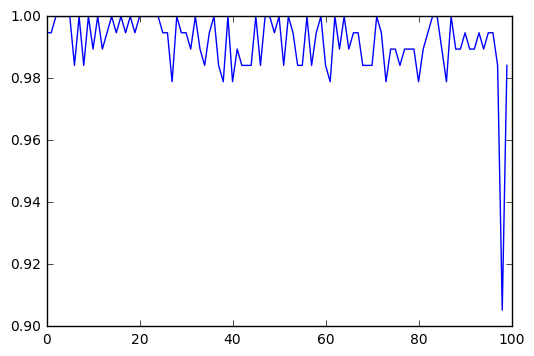

In [328]:
plt.plot(ac)

In [316]:
_,acc,probs = train(X/80., y)
print(acc)
print(probs[:,0])

0.8
[ 0.36719662  0.40660799  0.57041496  0.33072129  0.45370561  0.45407832
  0.50863695  0.40238538  0.48286411  0.53152955  0.50558054  0.50801206
  0.32494384  0.47777003  0.52850127  0.51639545  0.29548201  0.49180284
  0.57135868  0.35549077  0.350014    0.39521718  0.46729133  0.38506836
  0.43641284  0.30868211  0.5105437   0.52883267  0.47115323  0.33836389
  0.29969531  0.35589212  0.55398226  0.4842824   0.43501869  0.43351486
  0.58493263  0.40084299  0.2365595   0.54383057  0.52809626  0.40033388
  0.37315553  0.56908947  0.47884336  0.43278316  0.5169034   0.37965363
  0.39475796  0.57331127  0.31987154  0.51331002  0.28010756  0.49407482
  0.5440225   0.50876039  0.49291655  0.35869384  0.51518691  0.52406651
  0.54272789  0.52418685  0.56871462  0.43818012  0.36351714  0.53062278
  0.41887322  0.58648843  0.50005382  0.54687464  0.53556478  0.55910975
  0.52807182  0.52259839  0.53678924  0.50973964  0.34841487  0.34940174
  0.35216692  0.52335775  0.53221858  0.4348873

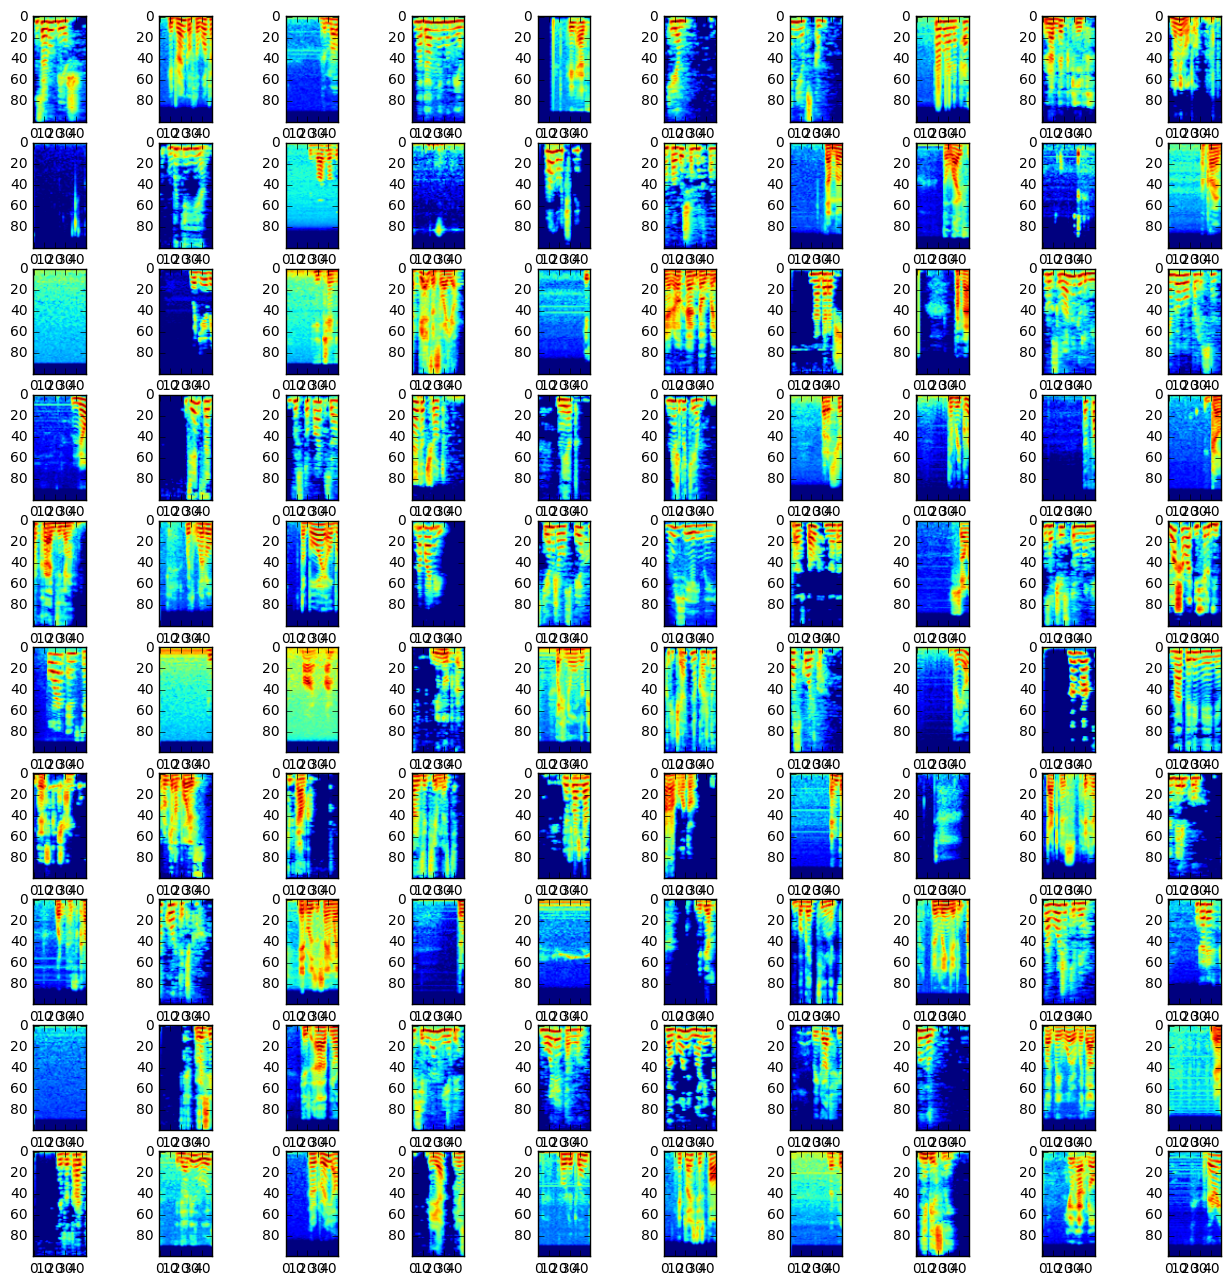

In [207]:
plt.figure(figsize=[16,16])
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(X[i])